In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score,hamming_loss, roc_curve, auc, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline,Pipeline
from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pickle
nltk.download('punkt')
nltk.download("stopwords")

import torch
from torch.utils.data import RandomSampler, SequentialSampler, DataLoader
from torch.utils.data import  Subset, TensorDataset
from transformers import BertForSequenceClassification, BertModel, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn import functional as F 

import random

from collections import defaultdict
import re 

import time

import torch.nn as nn

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [41]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [4]:
train.head()

In [5]:
submission.head()

In [6]:
train.isna().sum()

As we can see, we have missing values for the locations and keywords.

But this will not be very important since we are focusing on the text sentiment whether it s a disaster tweet or not

Lets perform some EDA analysis!!!

# EDA

In [7]:
# Target count
plt.figure(figsize = (8,6))
sns.countplot(x='target',data = train)
plt.xlabel("Target Values")
plt.ylabel("Count Values")
sns.despine(left = True, bottom = True)
plt.show()

In [22]:
# Plottin the most repetitive words in "text" column
stopwords = set(STOPWORDS)
def word_cloud(data, title = None):
    cloud = WordCloud(background_color = "black",
      stopwords = stopwords,
      max_words=200,
      max_font_size=40, 
      scale=3,).generate(str(data))
    fig = plt.figure(figsize= (8, 6))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=10)
        fig.subplots_adjust(top=0.8)

    plt.imshow(cloud)
    plt.show()

In [23]:
# Most repeated words in real disaster tweets,
#making a word cloud
word_cloud(train[train["target"] == 1]["text"], "Most repeated words in real disaster tweets in train data")

Words like :
- Fire 
- earthquake
- wildfires
- Deeds 
are references to a disaster happening 

Lets check the words distribution by tweets (disaster/No disaster)

In [24]:
# Distribution of keywords in real and fake tweets 
plt.figure(figsize = (10, 80), dpi = 100)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
sns.countplot(y = "keyword", hue = "target", data = train)
plt.legend(loc = 1)
plt.show()

Lets move on to the intresting part.
We are going to build two classifiers: 

- Ensemble Method: XGBoostClassifier from xgboost in which we are going to use TF-IDF vectorization and fine tune its hyper-parameters in order to get the best model

- Transormers: Bert Method from Hugging face library and fine tune its weights with regards to our train process

# Ensemble Method: XGBoost

for this part we will perform two steps: 

- First the cleaning which will be a bit harch 
- Next the fine tuning of the hyper-parameters we will define

## Text Pre-Processing

In [25]:
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Substitute some non sense words 
    s = re.sub(r"\x89Û_", "", s)
    s = re.sub(r"\x89ÛÒ", "", s)
    s = re.sub(r"\x89ÛÓ", "", s)
    s = re.sub(r"\x89ÛÏWhen", "When",s)
    s = re.sub(r"\x89ÛÏ", "", s)
    s = re.sub(r"China\x89Ûªs", "China's", s)
    s = re.sub(r"let\x89Ûªs", "let's",s)
    s = re.sub(r"\x89Û÷", "", s)
    s = re.sub(r"\x89Ûª", "", s)
    s = re.sub(r"\x89Û\x9d", "", s)
    s = re.sub(r"å_", "", s)
    s = re.sub(r"\x89Û¢", "", s)
    s = re.sub(r"\x89Û¢åÊ", "", s)
    s = re.sub(r"fromåÊwounds", "from wounds",s)
    s = re.sub(r"åÊ", "", s)
    s = re.sub(r"åÈ", "", s)
    s = re.sub(r"JapÌ_n", "Japan", s)    
    s = re.sub(r"Ì©", "e", s)
    s = re.sub(r"å¨", "", s)
    s = re.sub(r"SuruÌ¤", "Suruc", s)
    s = re.sub(r"åÇ", "", s)
    s = re.sub(r"å£3million", "3 million", s)
    s = re.sub(r"åÀ", "", s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [29]:
# apply the function on the text feature
train['text']=train['text'].apply(text_preprocessing)

## Setting the data: TF-IDF Vectorizer

In [30]:
X = train['text'].values
y = train['target'].values
  
# initializing TfidfVectorizer 
vectorizar = TfidfVectorizer(max_features=3000, max_df=0.85)
# fitting the tf-idf on the given data
vectorizar.fit(X)
  
# splitting the data to training and testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
  
# transforming the data
X_train_tfidf = vectorizar.transform(X_train)
X_test_tfidf = vectorizar.transform(X_test)

## Fine tuning XGboost hyper-parameters

In [31]:
params = {'estimator__learning_rate' :[0.01, 0.1, 0.2],
          'estimator__n_estimators':[10,100,500],
          'estimator__subsample':(0.2,0.6,0.8),
          'estimator__max_depth':np.arange(1,6),
          'estimator__min_child_weight':np.arange(1,6)}
base_estimator = XGBClassifier()
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
rsearch_cv.fit(X_train_tfidf, y_train)

In [32]:
# Getting the best model out of the randomized search
model=rsearch_cv.best_estimator_

In [33]:
#re-fitting the model with the best hyper-parameter we have found yet
model.fit(X_train_tfidf, y_train)

Lets evaluate the model on the test set

In [36]:
#We first get the predictions and then we compute the accuracy score
predictions=model.predict(X_test_tfidf)
print(f'accuracy score:{accuracy_score(y_test,predictions)}')
print('\n')
print(classification_report(y_test,predictions))

Here it is! we have reached roughly 79% of accuracy on the test set which is a good result.

Lets check the transformer method and see what we will get

# Transformers: BERT& Pytorch

BERT (introduced in this paper) stands for Bidirectional Encoder Representations from Transformers. If you don’t know what most of that means - you’ve come to the right place! Let’s unpack the main ideas:

- Bidirectional: to understand the text you’re looking you’ll have to look back (at the previous words) and forward (at the next words)
- Transformers: The Attention Is All You Need paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim).


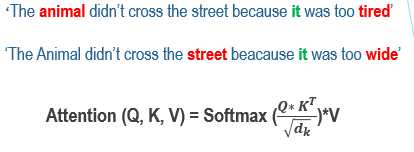

As yo may noticed in the above sentences: 
- the word (it) can be related to the animale (sentence 1)
- the word (it) is obviosly related to the street (sentence 2) 

Thanks to the attention mechanism given by the equation above, the word/token (it) won't have the same embedding since it has different meaning.

## Text cleaning for BERT

The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences and needs the whole sequence in order to capture each word meaning.

In [38]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Substitute some non sense words 
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    text = re.sub(r"\x89ÛÏWhen", "When",text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"China\x89Ûªs", "China's", text)
    text = re.sub(r"let\x89Ûªs", "let's",text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"fromåÊwounds", "from wounds",text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"JapÌ_n", "Japan", text)    
    text = re.sub(r"Ì©", "e", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"SuruÌ¤", "Suruc", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"å£3million", "3 million", text)
    text = re.sub(r"åÀ", "", text)

    return text

In [43]:
# Applying the cleaning functions to the train and test data
train['text']=train['text'].apply(text_preprocessing)
test['text']=test['text'].apply(text_preprocessing)

### Initialising the Tokenizer

In [44]:
# Setting the tokenizer parameters
BERT_MODEL_NAME='bert-base-cased'
tokeniser=BertTokenizer.from_pretrained(BERT_MODEL_NAME)

We have used the cased version of BERT because we want to capture the meaningful UPPERCASED Words 

## Setting the Input in BERT format 

In [46]:
# First we need to split the training data into train, validation datasets
texts, targets = train['text'].values, train['target'].values
texts_train, texts_test, targets_train, targets_test = train_test_split(texts, targets, test_size=0.15, random_state=42, stratify=targets)

Next we are going to prepare our data in a format that BERT understands: 
- inputs_ids: the token ids which will be embedded in pytorch tensor with bert dimensions 
- attention_mask: token encoding with 1 for a token and a 0 for padding 
- Label: the target for each input

All of these parameters will be wrapped inside a Tensor dataset which will be included in a batch dalaloader for trainning and validation datasets

In [48]:
def get_input(df,labels,train=True):
  input_ids=[]
  attention_masks=[]
  
  for sentence in df:
    
    # we prepare the encoding for each sentence in the dataset
    encoding=tokeniser.encode_plus(
                    sentence,
                    None,
                    add_special_tokens=True,
                    max_length= 64,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors ='pt')
    
    # We gather the tensors in two lists
    input_ids.append(encoding['input_ids'])
    attention_masks.append(encoding['attention_mask'])

  #convert inputs to tensors

  input_ids=torch.cat(input_ids,dim=0)
  attention_masks=torch.cat(attention_masks,dim=0)
  labels=torch.tensor(labels)
    
    
  # we wrap the inputs ensemble inside a TensorDataset
  dataset=TensorDataset(input_ids,attention_masks,labels)

  if train:
    sampler=RandomSampler(dataset)
  else:
    sampler=SequentialSampler(dataset)
  
  dataloader=DataLoader(dataset,sampler=sampler, batch_size=16)

  return dataloader

In [49]:
# Next we set the batches for the training and validation
#the batch size is the recommanded by the 'attention is all you need' paper
train_batches=get_input(texts_train,targets_train)
val_batches=get_input(texts_test,targets_test,train=False)

## Build the BERT-Classifier

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use BertForSequenceClassification, BertForQuestionAnswering or something else.
We can choose the **BertForSequenceClassification** for this task. Instead we want to try something else! We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model:

In [50]:
class Bertclf(nn.Module):

  def __init__(self):

    super(Bertclf,self).__init__()
    self.bert=BertModel.from_pretrained('bert-base-cased',return_dict=False)
    # We are adding a dropout layer
    self.drop=nn.Dropout(0.33)
    # on top of our bert model we added a Linear model with two hidden layers 
    self.classifier=torch.nn.Sequential(nn.Linear(768,256),
                                        nn.ReLU(),
                                        nn.Linear(256,50),
                                        nn.ReLU(),
                                        nn.Linear(50,2))
  # the output has two nodes for our binary classification model

  def forward(self, input_ids,attention_mask):

    last_hidden_state,pooled_output= self.bert(input_ids,attention_mask)
    output=self.drop(pooled_output)
    output=self.classifier(output)

    return output

In [53]:
#Instantiate the BERT Model & assign it to the GPU
model=Bertclf()
model.to('cuda')

### Training parameters

In [54]:
# setting the loss function which will be the CrossEntropyLoss
loss_fn=nn.CrossEntropyLoss().to('cuda')
#Recommended EPOCHS for training in order not to overfit
N_EPOCHS=4
# optimiser will perform the weights update as its first param
#learning rate 5e-5 
#epsilon 1e-8
optimiser=AdamW(model.parameters(),
                lr=5e-5,
                eps=1e-08)
  
total_steps = len(train_batches) * N_EPOCHS
# the schedular updates the learning rate each step
schedular=get_linear_schedule_with_warmup(optimiser,
                                          num_warmup_steps=0,
                                          num_training_steps=total_steps)

### Helper functions for Training/Validation

In [55]:
def train_loop(train_loader,optimizer,Schedular):

  #Set the model in training mode  
  model.train()
  

  #We are storing the losses and the good predictions
  losses=[]
  correct_predicitons=0

  for step, batch in enumerate(train_loader):
    
    #the model should not store the previous gradient 
    model.zero_grad()


    #sending the batches input to the GPU
    input,atten,label=(t.to('cuda') for t in batch)
    logit=model(input,atten)
    loss=loss_fn(logit,label)

    #First we apply the softmax on the logits to get the probabilities distribution
    #Next the max function give us the max value index
    pred=torch.max((F.softmax(logit, dim=1)), dim=1)[1]
    correct_predicitons+= torch.sum(pred==label)

    losses.append(loss.item())


    #we perform the backpropagation on the loss and store in the predicitons
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(),1.0)

    #we update the model parameters with the learning rate
    optimizer.step()
    Schedular.step()

  return correct_predicitons/len(texts_train) , np.mean(losses)

In [57]:
def validation_loop(val_loader,len_input):

  #Next we switch to the evaluation mode  
  model.eval()

  losses=[]
  correct_predicitons=0

  for batch in (val_loader):

      
      input,atten,label=(t.to('cuda') for t in batch)
    
      #No Backpropagation is needed only the feed forward step
      with torch.no_grad():
        logit=model(input,atten)

      loss=loss_fn(logit,label)

      pred=torch.max((F.softmax(logit, dim=1)), dim=1)[1]
      
      correct_predicitons+= torch.sum(pred==label)

      losses.append(loss.item())

  return correct_predicitons/len_input , np.mean(losses)

### the Training/Validation Process

In [59]:
history=defaultdict(list)

best_accuracy=0

for epoch in range(N_EPOCHS):

  print(f'Epoch: {epoch+1}/{N_EPOCHS}')
  print('-'*10)

  train_acc,train_loss=train_loop(train_batches,optimiser,schedular)

  print(f'Train accuracy: {train_acc} ; Train loss: {train_loss}')


  val_acc, val_loss= validation_loop(val_batches,len(texts_test))
  
  print(f'val accuracy: {val_acc} ; val loss: {val_loss}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), './best_model_state.bin' )
    best_accuracy = val_acc

As we can see, we haven't done any improvment since the first. which is can be concluded with regards to the **val_loss** as it s increasing then stays the same

## Evaluating the model

this the input format for the unlabled dataset. the test dataset in our case 

In [60]:
def eval_input(df):
  input_ids=[]
  attention_masks=[]
  
  for sentence in df:
    
    encoding=tokeniser.encode_plus(
                    sentence,
                    None,
                    add_special_tokens=True,
                    max_length= 64,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors ='pt')
    
    input_ids.append(encoding['input_ids'])
    attention_masks.append(encoding['attention_mask'])

  #convert inputs to tensors

  input_ids=torch.cat(input_ids,dim=0)
  attention_masks=torch.cat(attention_masks,dim=0)


  dataset=TensorDataset(input_ids,attention_masks)

  dataloader=DataLoader(dataset,sampler=SequentialSampler(dataset), batch_size=16)

  return dataloader

In [61]:
#prepare the test batches
test_batches=eval_input(test['text'].values)

In [64]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to('cuda') for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu()
    pred=list(torch.max(probs.detach(),dim=1)[1].numpy())

    return pred, probs

In [65]:
predictions, probabilities=bert_predict(model,test_batches)

In [67]:
test_predictions_dt=pd.DataFrame({'text':test['text'].values.tolist(),'predictions':predictions})
test_predictions_dt.sample(10)

### Evaluation on the validation dataset

In [68]:
predictions, probabilities=bert_predict(model,val_batches)
print(classification_report(list(targets_test), predictions))

In [69]:
def show_confusion_matrix(confusion_matrix):

  plt.figure(figsize=(12,10))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')
  plt.show()

cm = confusion_matrix(list(targets_test), predictions)
df_cm = pd.DataFrame(cm, index=['disaster','no_disaster'], columns=['disaster','no_disaster'])
